# Field projections

To run this notebook from your browser, click [here](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FFieldProjections.ipynb).

This tutorial will show you how to use field projections to obtain electromagnetic field data far away from a structure with knowledge of only near-field data.

When projecting fields, geometric approximations can be invoked to allow computing fields far away from the structure quickly and with good accuracy, but in `Tidy3D` we can also turn these approximations off when projecting fields at intermediate distances away, which gives a lot of flexibility.

These field projections are particularly useful for eliminating the need to simulate large regions of empty space around a structure. 

In this notebook, we will
* show how to compute projected fields on your local machine after a simulation is run, or on our servers during the simulation run;
* show how to extract various quantities related to projected fields such as fields in different coordinate systems, power, and radar cross section;
* demonstrate how, when far field approximations are used, the fields can dynamically be re-projected to new distances without having to run a new simulation;
* study when geometric far field approximations should and should not be invoked, depending on the projection distance and the geometry of the structure;
* show how to set up projections for finite-sized objects (e.g., scattering at a sphere) vs. thin but large-area structures (e.g., metasurfaces).

## Table of contents
1. [Simulation setup](#setup)
2. [Far-field projector setup](#farfield1)
3. [Server-side far field projection](#farfieldserver1)
4. [Coordinate system conversion, power computation](#powercoords)
5. [Re-projection to a new far field distance](#reproj)
6. [Exact field projections without making the far-field approximation](#exact)
7. [Projection to a grid defined in reciprocal space](#kspace)
8. [Some final notes](#notes)


In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web


[18:58:09] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=551849;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=850621;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#102\102]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.8.2                                                     ]8;id=579290;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=13306;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#120\120]8;;\

## Far Field for a Uniformly Illuminated Aperture <a name="setup"></a>

First, we will consider the simple case of an aperture in a perfect electric conductor sheet illuminated by a plane wave. The far fields in this case are known analytically, which allows for a straightforward comparison to `Tidy3D`'s field projection functionality. We will show how to compute the far fields both on your local machine, and on the server. The geometry is shown below.

<img src="img/far_field_aperture.png" width=350>

### Geometry setup

In [2]:
# size of the aperture (um)
width = 1.5
height = 2.5

# free space central wavelength (um)
wavelength = 0.75
# center frequency
f0 = td.C_0 / wavelength

# Define materials
air = td.Medium(permittivity=1)
pec = td.PECMedium()

# PEC plate thickness
thick = 0.2

# FDTD grid resolution
min_cells_per_wvl = 20

# create the PEC plate
plate = td.Structure(
    geometry=td.Box(size=[td.inf, thick, td.inf], center=[0, 0, 0]), medium=pec
)

# create the aperture in the plate
aperture = td.Structure(
    geometry=td.Box(size=[width, 1.5 * thick, height], center=[0, 0, 0]), medium=air
)

# make sure to append the aperture to the plate so that it overrides that region of the plate
geometry = [plate, aperture]

# define the boundaries as PML on all sides
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

# set the total domain size in x, y, and z
sim_size = [width * 2, 2, height * 2]


### Source setup
For our incident field, we create a plane wave incident from the left, with the electric field polarized in the -z direction.

In [3]:
# bandwidth in Hz
fwidth = f0 / 10.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.0

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, offset=offset)

# place the source to the left, propagating in the +y direction
offset_src = -0.3
source = td.PlaneWave(
    center=(0, offset_src, -0),
    size=(td.inf, 0, td.inf),
    source_time=gaussian,
    direction="+",
    pol_angle=np.pi / 2,
)

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 40 / fwidth


### Create monitor

First, we'll see how to do field projections using your machine after you've downloaded near fields from a `Tidy3D` simulation.

We create a surface [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html) just to the right of the aperture to capture the near field data in the frequency domain.

In [4]:
offset_mon = 0.3
monitor_near = td.FieldMonitor(
    center=[0, offset_mon, 0], size=[td.inf, 0, td.inf], freqs=[f0], name="near_field"
)


### Create Simulation

Now we can put everything together and define the simulation with a simple uniform mesh, and then we'll visualize the geometry to make sure everything looks right.

<AxesSubplot: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

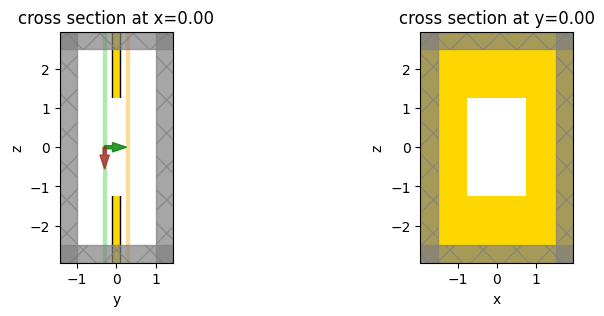

In [5]:
sim = td.Simulation(
    size=sim_size,
    center=[0, 0, 0],
    grid_spec=td.GridSpec.uniform(dl=wavelength / min_cells_per_wvl),
    structures=geometry,
    sources=[source],
    monitors=[monitor_near],
    run_time=run_time,
    boundary_spec=boundary_spec,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sim.plot(x=0, ax=ax1)
sim.plot(y=0, ax=ax2)


### Run simulation

In [6]:
sim_data = web.run(sim, task_name="aperture_1", path="data/aperture_1.hdf5")


           INFO     Using Tidy3D credentials from stored file.                                           ]8;id=218458;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=317779;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#70\70]8;;\

[18:58:11] INFO     Authentication successful.                                                           ]8;id=232843;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=179912;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#30\30]8;;\

           INFO     Created task 'aperture_1' with task_id '9c8ce442-acf3-4a6a-b0db-271fb500b22b'.    ]8;id=814843;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=664334;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[18:58:13] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=740206;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=448469;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                                                   ]8;id=839105;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=941212;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#261\261]8;;\

Output()

[18:58:16] INFO     status = preprocess                                                               ]8;id=240437;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=219729;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#273\273]8;;\

[18:58:19] INFO     starting up solver                                                                ]8;id=372866;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=282437;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#277\277]8;;\

[18:58:26] INFO     running solver                                                                    ]8;id=914108;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=4886;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#283\283]8;;\

Output()

[18:58:28] INFO     early shutoff detected, exiting.                                                  ]8;id=887821;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=841171;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                                              ]8;id=434382;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=995877;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[18:58:30] INFO     status = success                                                                  ]8;id=422003;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=51473;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

[18:58:31] INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=597962;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=769269;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/aperture_1.hdf5"             ]8;id=530333;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=389133;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#592\592]8;;\

Output()

[18:58:33] INFO     loading SimulationData from data/aperture_1.hdf5                                  ]8;id=510694;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=768222;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#414\414]8;;\

### Far field points <a name="farfield1"></a>
Now, we'll define the set of observation angles far away from the source at which we'd like to measure the far fields.

In [7]:
# radial distance away from the origin at which to project fields
r_proj = 50 * wavelength

# theta and phi angles at which to observe fields - part of the half-space to the right
theta_proj = np.linspace(np.pi / 10, np.pi - np.pi / 10, 100)
phi_proj = np.linspace(np.pi / 10, np.pi - np.pi / 10, 100)


Now, we define a far-field monitor, [FieldProjectionAngleMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionAngleMonitor), which stores the information regarding the far field projection grid, and then we define the object that does the actual projections, [FieldProjector](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjector).

In [8]:
# far field projection monitor
monitor_far = td.FieldProjectionAngleMonitor(
    center=[
        0,
        offset_mon,
        0,
    ],  # the monitor's center defined the local origin - the projection distance
    # and angles will all be measured with respect to this local origin
    size=[td.inf, 0, td.inf],
    # the size and center of any far field monitor should indicate where the *near* fields are recorded
    freqs=[f0],
    name="far_field",
    phi=list(phi_proj),
    theta=list(theta_proj),
    proj_distance=r_proj,
    far_field_approx=True,  # we leave this to its default value of 'True' because we are interested in fields sufficiently
    # far away that geometric far field approximations can be invoked to speed up the calculation
)

# helper functin to call the projector
def get_proj_fields(sim_data, monitor_near, monitor_far, pts_per_wavelength=10):
    # object that does projections is constructed using the near-field monitor, because those are the fields to be projected
    projector = td.FieldProjector.from_near_field_monitors(
        sim_data=sim_data,
        near_monitors=[monitor_near],
        normal_dirs=["+"],  # we are projecting along the + direction
        pts_per_wavelength=pts_per_wavelength,  # to speed up calculations, the fields on the near-field monitor can be downsampled to these
        # many points per wavelength (default is already 10)
    )
    return projector.project_fields(monitor_far)


# execute the projector, with the far field monitor as input, to do the projection
# let's also time this, for later use
import time

t0 = time.perf_counter()
projected_field_data = get_proj_fields(sim_data, monitor_near, monitor_far)
t1 = time.perf_counter()
proj_time = t1 - t0


Output()

### Analytical solution
Before we plot and analyze the results, we need reference data with which to perform comparisons. In our simple aperture example, an analytical expression for the far fields is already available, so we'll simply implement the analytic formula here at the observation points of interest.

In [9]:
def analytic_fields_aperture(
    proj_monitor, sim_size, aperture_height, aperture_width, r_proj
):
    """Compute the far fields analytically."""
    # in Tidy3D, the plane wave source is normalized so that a total flux of 1 is injected into the simulation domain,
    # which corresponds to an electric field strength that is inversely proportional to the square root of the in-plane domain area
    thetas_ext = np.array(proj_monitor.theta)[None, :, None, None]
    phis_ext = np.array(proj_monitor.phi)[None, None, :, None]
    f = np.array(proj_monitor.freqs)[None, None, None, :]
    E0 = np.sqrt(2.0 * td.ETA_0 / sim_size[0] / sim_size[2])
    k = 2.0 * np.pi * f / td.C_0
    ux = k * np.sin(thetas_ext) * np.cos(phis_ext) * aperture_width / 2.0
    uz = k * np.cos(thetas_ext) * aperture_height / 2.0
    Etheta = (
        -k
        / 2.0
        / np.pi
        / r_proj
        * E0
        * np.sin(thetas_ext)
        * np.exp(1j * k * r_proj)
        * aperture_height
        * aperture_width
        * np.sinc(ux / np.pi)
        * np.sinc(uz / np.pi)
    )
    Hphi = Etheta / td.ETA_0

    # for convenience, let's encapsulate the data into one of Tidy3D's native data structures designed for
    # storing far fields - this is the same format in which data will be returned when using Tidy3D's
    # 'FieldProjector', so comparisons will be easier to make
    coords = dict(
        r=np.array([r_proj]),
        theta=np.array(proj_monitor.theta),
        phi=np.array(proj_monitor.phi),
        f=np.array(proj_monitor.freqs),
    )
    Etheta_data = td.FieldProjectionAngleDataArray(Etheta, coords=coords)
    Hphi_data = td.FieldProjectionAngleDataArray(Hphi, coords=coords)
    Er_data = td.FieldProjectionAngleDataArray(np.zeros_like(Etheta), coords=coords)
    Ephi_data = td.FieldProjectionAngleDataArray(np.zeros_like(Etheta), coords=coords)
    Hr_data = td.FieldProjectionAngleDataArray(np.zeros_like(Etheta), coords=coords)
    Htheta_data = td.FieldProjectionAngleDataArray(np.zeros_like(Etheta), coords=coords)
    return td.FieldProjectionAngleData(
        monitor=proj_monitor,
        Er=Er_data,
        Etheta=Etheta_data,
        Ephi=Ephi_data,
        Hr=Hr_data,
        Htheta=Htheta_data,
        Hphi=Hphi_data,
        projection_surfaces=proj_monitor.projection_surfaces,
    )


analytic_field_data = analytic_fields_aperture(
    monitor_far, sim_size, height, width, r_proj
)


### Plot and compare
Now we can compare the analytic fields to those computed via `Tidy3D`'s [FieldProjector](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjector), and also compute the root mean squared error between the two.

Normalized root mean squared error: 4.51 %


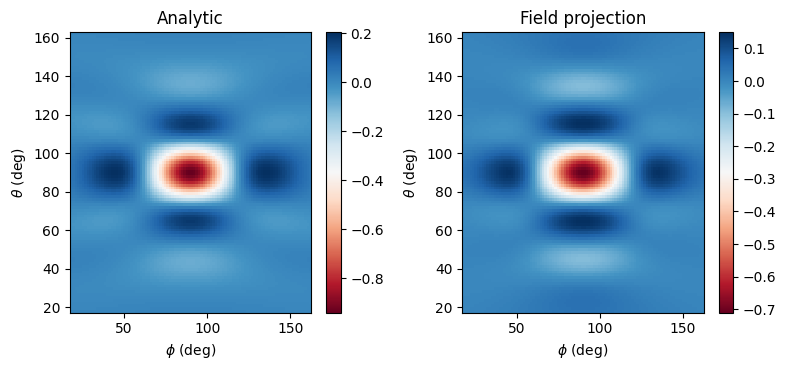

In [10]:
def make_field_plot(phi, theta, vals1, vals2):
    n_plots = 2
    fig, ax = plt.subplots(1, n_plots, tight_layout=True, figsize=(8, 3.8))
    im1 = ax[0].pcolormesh(
        phi * 180 / np.pi,
        theta * 180 / np.pi,
        np.real(vals1),
        cmap="RdBu",
        shading="auto",
    )
    im2 = ax[1].pcolormesh(
        phi * 180 / np.pi,
        theta * 180 / np.pi,
        np.real(vals2),
        cmap="RdBu",
        shading="auto",
    )
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    ax[0].set_title("Analytic")
    ax[1].set_title("Field projection")
    for _ax in ax:
        _ax.set_xlabel("$\phi$ (deg)")
        _ax.set_ylabel("$\\theta$ (deg)")


# RMSE
def rmse(array_ref, array_test):
    error = array_test - array_ref
    rmse = np.sqrt(np.mean(np.abs(error.flatten()) ** 2))
    nrmse = rmse / np.abs(np.max(array_ref.flatten()) - np.min(array_ref.flatten()))
    return nrmse


# plot Etheta
Etheta_analytic = analytic_field_data.Etheta.isel(f=0, r=0)
Etheta_proj = projected_field_data.Etheta.isel(f=0, r=0)
make_field_plot(phi_proj, theta_proj, Etheta_analytic, Etheta_proj)

# print the normalized RMSE
print(
    f"Normalized root mean squared error: {rmse(Etheta_analytic.values, Etheta_proj.values) * 100:.2f} %"
)

plt.show()


We obtain good agreement to analytical results. Now let's see if we can repeat this simulation but compute the far fields on the server, during the simulation run.

### Server-side field projection <a name="farfieldserver1"></a>
All we have to do is provide the [FieldProjectionAngleMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionAngleMonitor) monitor as an input to the `Tidy3D` `Simulation` object as one of its `monitors`. Now, we no longer need to provide a separate near-field [FieldMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor) - the near fields will automatically be recorded based on the size and location of the [FieldProjectionAngleMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionAngleMonitor).

In [11]:
sim2 = td.Simulation(
    size=sim_size,
    center=[0, 0, 0],
    grid_spec=td.GridSpec.uniform(dl=wavelength / min_cells_per_wvl),
    structures=geometry,
    sources=[source],
    monitors=[
        monitor_far
    ],  # just provide the far field FieldProjectionAngleMonitor as the input monitor
    run_time=run_time,
    boundary_spec=boundary_spec,
)


Run the new simulation.

In [12]:
sim_data2 = web.run(sim2, task_name="aperture_2", path="data/aperture_2.hdf5")


[18:58:35] INFO     Created task 'aperture_2' with task_id '3d09f896-df71-4398-9938-011328acfa04'.    ]8;id=983454;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=401954;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[18:58:37] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=345173;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=844342;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                                                   ]8;id=463959;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=633209;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#261\261]8;;\

Output()

[18:58:40] INFO     status = preprocess                                                               ]8;id=385681;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=637460;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#273\273]8;;\

[18:58:43] INFO     starting up solver                                                                ]8;id=961933;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=171390;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#277\277]8;;\

[18:58:50] INFO     running solver                                                                    ]8;id=384148;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=868350;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#283\283]8;;\

Output()

[18:58:52] INFO     early shutoff detected, exiting.                                                  ]8;id=374015;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=673594;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                                              ]8;id=884992;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=459933;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[18:58:54] INFO     status = success                                                                  ]8;id=296555;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=148711;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=782853;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=418754;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/aperture_2.hdf5"             ]8;id=997938;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=892902;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#592\592]8;;\

Output()

[18:58:56] INFO     loading SimulationData from data/aperture_2.hdf5                                  ]8;id=561641;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=708634;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#414\414]8;;\

Now the projected fields are already contained in the returned `sim_data2` object - all we have to do is access it as follows, and then plot and compare to analytical results as before.

Normalized root mean squared error: 4.51 %


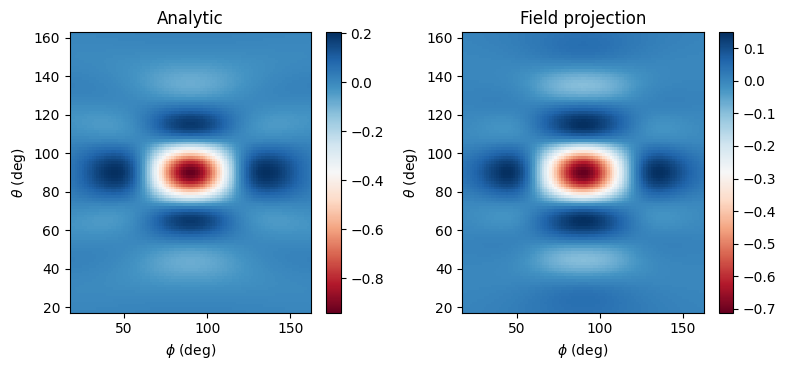

In [13]:
# extract the computed projected fields
projected_field_data_server = sim_data2[monitor_far.name]

# plot Etheta
Etheta_proj_server = projected_field_data_server.Etheta.isel(f=0, r=0)
make_field_plot(phi_proj, theta_proj, Etheta_analytic, Etheta_proj_server)

# print the normalized RMSE
print(
    f"Normalized root mean squared error: {rmse(Etheta_analytic.values, Etheta_proj_server.values) * 100:.2f} %"
)

plt.show()


We obtain nearly identical results, except that they are computed much faster on our servers. Note also that in some cases, the server-side computations may be slightly more accurate than client-side ones, because on the server, the near fields are not downsampled at all.

To see the performance gains of using server-side computations, let's compare the time taken in each case.

In [14]:
# use the simulation log to find the time taken for server-side computations
server_time = float(
    sim_data2.log.split("Field projection time (s):    ", 1)[1].split("\n", 1)[0]
)
print(f"Client-side field projection took {proj_time:.2f} s")
print(f"Server-side field projection took {server_time:.2f} s")


Client-side field projection took 1.72 s
Server-side field projection took 0.67 s


As expected, the server computes far fields faster than the local CPU-based computation, though it's a relatively small gain in this case. The gains in computation time are expected to be greater for larger and more complex setups.

### Other far field quantities and coordinate systems <a name="powercoords"></a>
So far, we've been looking at the electric field in spherical coordinates. However, we can also look at the fields in other coordinate systems, e.g., `E_x`, `E_y`, `E_z`, and the radiated power, as follows:

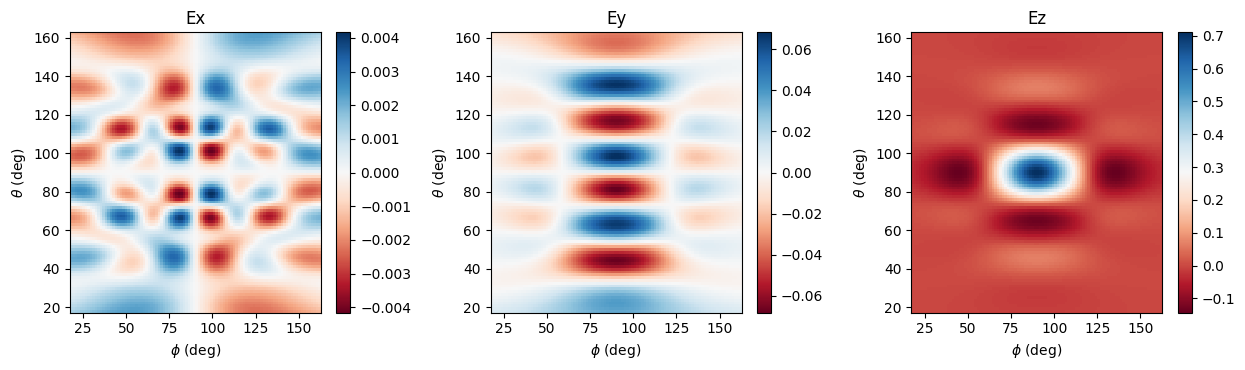

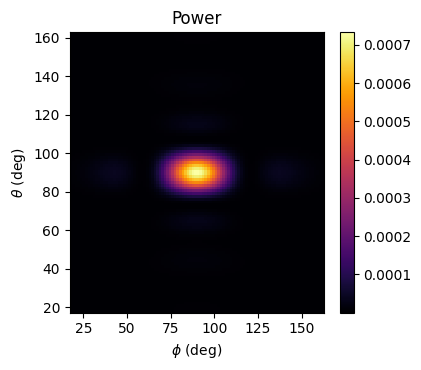

In [15]:
def make_cart_plot(phi, theta, vals1, vals2, vals3):
    n_plots = 3
    fig, ax = plt.subplots(1, n_plots, tight_layout=True, figsize=(12.6, 3.8))
    im1 = ax[0].pcolormesh(
        phi * 180 / np.pi,
        theta * 180 / np.pi,
        np.real(vals1),
        cmap="RdBu",
        shading="auto",
    )
    im2 = ax[1].pcolormesh(
        phi * 180 / np.pi,
        theta * 180 / np.pi,
        np.real(vals2),
        cmap="RdBu",
        shading="auto",
    )
    im3 = ax[2].pcolormesh(
        phi * 180 / np.pi,
        theta * 180 / np.pi,
        np.real(vals3),
        cmap="RdBu",
        shading="auto",
    )
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    fig.colorbar(im3, ax=ax[2])
    ax[0].set_title("Ex")
    ax[1].set_title("Ey")
    ax[2].set_title("Ez")
    for _ax in ax:
        _ax.set_xlabel("$\phi$ (deg)")
        _ax.set_ylabel("$\\theta$ (deg)")


# get the fields in Cartesian coordinates from the projected data we already computed above
fields_cartesian = projected_field_data.fields_cartesian.isel(f=0, r=0)

# plot Ex, Ey, Ez
make_cart_plot(
    phi_proj, theta_proj, fields_cartesian.Ex, fields_cartesian.Ey, fields_cartesian.Ez
)

# get the power
power = projected_field_data.power.isel(f=0, r=0)

# plot the power
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(4.3, 3.8))
im = ax.pcolormesh(
    phi_proj * 180 / np.pi,
    theta_proj * 180 / np.pi,
    power,
    cmap="inferno",
    shading="auto",
)
fig.colorbar(im, ax=ax)
_ = ax.set_title("Power")
_ = ax.set_xlabel("$\phi$ (deg)")
_ = ax.set_ylabel("$\\theta$ (deg)")

plt.show()


### Re-projection to a different distance <a name="reproj"></a>
We can re-project the already-computed far fields to a different distance away from the structure - _we neither need to run another simulation nor re-run the [FieldProjector](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjector)_. Instead, the fields can simply be renormalized as shown below.

Note that by default, if no `proj_distance` was provided in the [FieldProjectionAngleMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionAngleMonitor), the fields are projected to a distance of 1m.

Normalized root mean squared error: 4.51 %


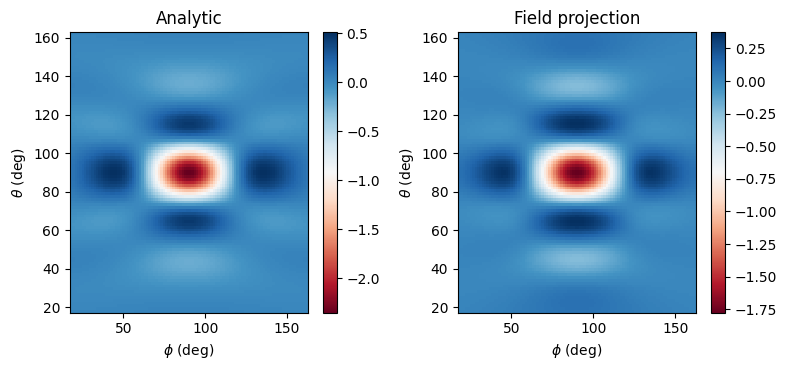

In [16]:
# new projection distance
r_proj_new = 20 * wavelength

# re-project our far field data above to this new distance
reprojected_field_data = projected_field_data.renormalize_fields(r_proj_new)

# now all the fields stored in 'projected_field_data' correspond to this new distance
# compare to the analytical fields at this new distance
analytic_field_data_new = analytic_fields_aperture(
    monitor_far, sim_size, height, width, r_proj_new
)

# plot Etheta
Etheta_analytic = analytic_field_data_new.Etheta.isel(f=0, r=0)
Etheta_proj = reprojected_field_data.Etheta.isel(f=0, r=0)
make_field_plot(phi_proj, theta_proj, Etheta_analytic, Etheta_proj)

# print the normalized RMSE
print(
    f"Normalized root mean squared error: {rmse(Etheta_analytic.values, Etheta_proj.values) * 100:.2f} %"
)

plt.show()


### More accurate field projections <a name="exact"></a>
In the field projections used above, the far field approximation is used: it is assumed that the fields are measured at a distance much greater than the size of our simulation in the transverse direction. Accordingly, geometric approximations are invoked, and any quantity whose magnitude drops off as 1/r^2 or faster is ignored. The advantages of these approximations are:
* the projections are computed relatively fast
* the projections are cast in a simple mathematical form which allows re-projecting the fields to different distance without the need to re-run a simulation or to re-run the [FieldProjector](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjector).

However, in some cases we may want to project to intermediate distances where the far field approximation is no longer valid. `Tidy3D`'s field projection functionality allows doing this very easily: simply flip a switch when defining the [FieldProjectionAngleMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionAngleMonitor)! The resulting computations will be a bit slower, but the results will be significantly more accurate.

_Note: when the far field approximations are turned off, we can no longer simply use `renormalize_fields` to re-project the fields at a new distance. Instead, we would need to re-run the [FieldProjector](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjector)._

Below, we will demonstrate this feature by looking at fields only a few wavelengths away from the aperture. Note that our analytical results also made far field approximations, so here we'll make our simulation domain a bit larger and measure the actual fields on a monitor, so that we can compare these actual fields to those computed by the [FieldProjector](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjector).

Also, this time we'll use the [FieldProjectionCartesianMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionCartesianMonitor), which is the counterpart to the [FieldProjectionAngleMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionAngleMonitor) where the observation grid is defined in Cartesian coordinates, not angles.

<AxesSubplot: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

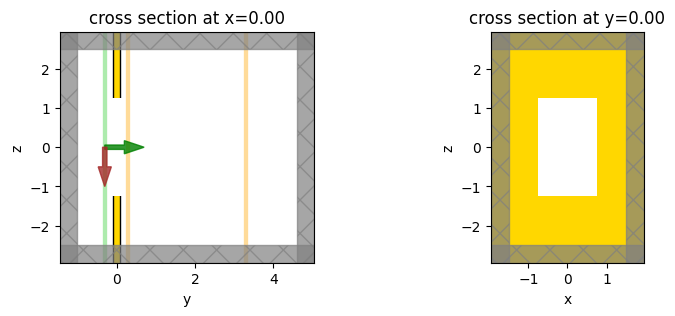

In [17]:
# project fields only a few wavelengths away from the aperture
r_proj_intermediate = 4 * wavelength

# create a field monitor to measure these fields at the intermediate projection distance,
# so that we have something to which we can compare the 'FieldProjector' results
monitor_intermediate = td.FieldMonitor(
    center=[0, offset_mon + r_proj_intermediate, 0],
    size=[td.inf, 0, td.inf],
    freqs=[f0],
    name="inter_field",
)

# make a larger simulation along y to accommodate the plane at which the intermediate fields need to be measured
shift = 1.2 * r_proj_intermediate
sim_size3 = [sim_size[0], sim_size[1] + shift, sim_size[2]]
# move the sim center
sim_center = [0, (sim_size[1] + shift) / 2 - sim_size[1] / 2, 0]
sim3 = td.Simulation(
    size=sim_size3,
    center=sim_center,
    grid_spec=td.GridSpec.uniform(dl=wavelength / min_cells_per_wvl),
    structures=geometry,
    sources=[source],
    monitors=[
        monitor_near,
        monitor_intermediate,
    ],  # provide both near field and intermediate field monitors
    run_time=run_time,
    boundary_spec=boundary_spec,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sim3.plot(x=0, ax=ax1)
sim3.plot(y=0, ax=ax2)


Run the new simulation.

In [18]:
sim_data3 = web.run(sim3, task_name="aperture_3", path="data/aperture_3.hdf5")


[18:58:58] INFO     Created task 'aperture_3' with task_id '667ee6e9-4665-4dab-a871-6880a113dd72'.    ]8;id=395059;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=771055;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[18:58:59] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=55585;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=604617;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                                                   ]8;id=272859;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=288947;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#261\261]8;;\

Output()

[18:59:06] INFO     starting up solver                                                                ]8;id=280853;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=404784;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#277\277]8;;\

[18:59:11] INFO     running solver                                                                    ]8;id=700669;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=294404;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#283\283]8;;\

Output()

[18:59:15] INFO     early shutoff detected, exiting.                                                  ]8;id=621587;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=103510;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                                              ]8;id=364769;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=949835;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[18:59:17] INFO     status = success                                                                  ]8;id=562141;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=241436;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=752913;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=714213;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#310\310]8;;\

[18:59:18] INFO     downloading file "output/monitor_data.hdf5" to "data/aperture_3.hdf5"             ]8;id=300853;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=920402;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#592\592]8;;\

Output()

[18:59:19] INFO     loading SimulationData from data/aperture_3.hdf5                                  ]8;id=507395;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=433090;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#414\414]8;;\

Now let's create the [FieldProjectionCartesianMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionCartesianMonitor), this time turning off the far field approximations, and then run the [FieldProjector](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjector) again.

The [FieldProjectionCartesianMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionCartesianMonitor)'s xy observation grid is defined in a local coordinate system whose z axis points in the direction along which we want to project fields, in this case the +y axis. The mapping between local and global coordinates is as follows:
* `proj_axis=0`: local x = global y, local y = global z
* `proj_axis=1`: local x = global x, local y = global z
* `proj_axis=2`: local x = global x, local y = global y

In [19]:
# make the projection monitor which projects fields without approximations
xs = np.linspace(-sim_size[0] / 2, sim_size[0] / 2, 100)
ys = np.linspace(-sim_size[1] / 2, sim_size[1] / 2, 100)
monitor_intermediate_proj = td.FieldProjectionCartesianMonitor(
    center=[
        0,
        offset_mon,
        0,
    ],  # the monitor's center defined the local origin - the projection distance
    # and angles will all be measured with respect to this local origin
    size=[td.inf, 0, td.inf],
    freqs=[f0],
    name="inter_field_proj",
    proj_axis=1,  # because we're projecting along the +y axis
    x=list(xs),  # local x coordinates - corresponds to global x in this case
    y=list(ys),  # local y coordinates - corresponds to global z in this case
    proj_distance=r_proj_intermediate,
    far_field_approx=False,  # turn off the far-field approximation (is 'True' by default)
)

# execute the projector, with the projection field monitor as input, to do the projection
# let's also time this, for later use
import time

t0 = time.perf_counter()
projected_field_data_noapprox = get_proj_fields(
    sim_data3, monitor_near, monitor_intermediate_proj
)
t1 = time.perf_counter()
proj_time_new = t1 - t0


Output()

Now let's compare the following three results:
* Directly-measured fields at the projection distance
* Projected fields with approximations turned off
* Projected fields with approximations turned on (just to compare the accuracy)

In [20]:
# Compute projected fields *with* far field approximations, to facilitate an accuracy comparison
monitor_intermediate_proj_approx = td.FieldProjectionCartesianMonitor(
    center=[
        0,
        offset_mon,
        0,
    ],  # the monitor's center defined the local origin - the projection distance
    # and angles will all be measured with respect to this local origin
    size=[td.inf, 0, td.inf],
    freqs=[f0],
    name="inter_field_proj_approx",
    proj_axis=1,  # because we're projecting along the +y axis
    x=list(xs),  # local x coordinates - corresponds to global x in this case
    y=list(ys),  # local y coordinates - corresponds to global z in this case
    proj_distance=r_proj_intermediate,
    far_field_approx=True,  # turn on the far-field approximation
)

# execute the projector, with the projection field monitor as input, to do the projection
# let's also time this, for later use
import time

t0 = time.perf_counter()
projected_field_data_approx = get_proj_fields(
    sim_data3, monitor_near, monitor_intermediate_proj_approx
)
t1 = time.perf_counter()
proj_time_new_approx = t1 - t0


Output()

In [21]:
# let's see how long this took compared to the previous case when the approximations were turned on
print(
    f"Client-side field projection *with approximations on* took {proj_time_new_approx:.2f} s"
)
print(
    f"Client-side field projection *with approximations off* took {proj_time_new:.2f} s"
)


Client-side field projection *with approximations on* took 3.43 s
Client-side field projection *with approximations off* took 11.41 s


As expected, when the approximations are turned off, the projections take longer. Now let's see if it was worth it!

In [22]:
# Helper function to plot fields
def make_cart_plot(phi, theta, vals1, vals2, vals3):
    n_plots = 3
    fig, ax = plt.subplots(1, n_plots, tight_layout=True, figsize=(9, 3))
    im1 = ax[0].pcolormesh(ys, xs, np.real(vals1), cmap="RdBu", shading="auto")
    im2 = ax[1].pcolormesh(ys, xs, np.real(vals2), cmap="RdBu", shading="auto")
    im3 = ax[2].pcolormesh(ys, xs, np.real(vals3), cmap="RdBu", shading="auto")
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    fig.colorbar(im3, ax=ax[2])
    ax[0].set_title("Ex")
    ax[1].set_title("Ey")
    ax[2].set_title("Ez")
    for _ax in ax:
        _ax.set_xlabel("$y$ (micron)")
        _ax.set_ylabel("$x$ (micron)")


Normalized RMSE for |E|, no far field approximation: 0.59 %
Normalized RMSE for |E|, with far field approximation: 23.17 %


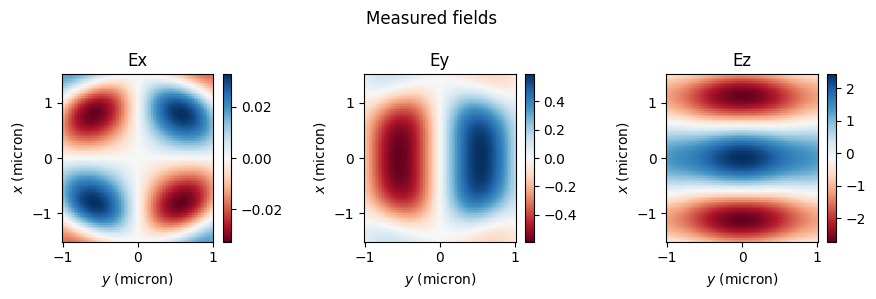

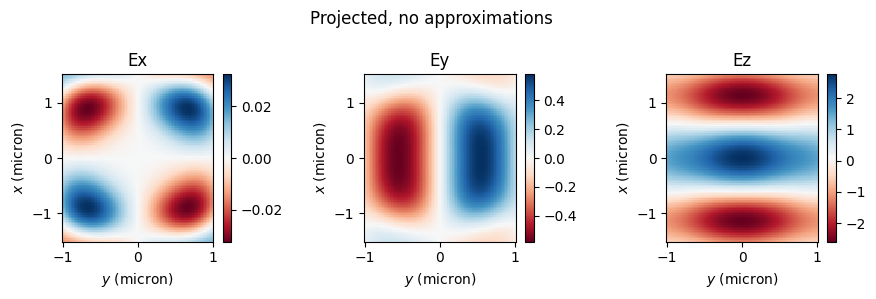

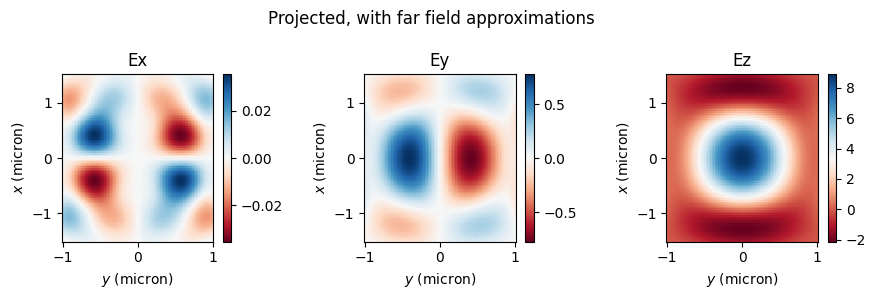

In [23]:
# plot the actual measured fields
fields_meas = sim_data3[monitor_intermediate.name].colocate(x=xs, z=ys)
make_cart_plot(
    ys,
    xs,
    fields_meas.Ex.isel(f=0, y=0),
    fields_meas.Ey.isel(f=0, y=0),
    fields_meas.Ez.isel(f=0, y=0),
)
plt.suptitle("Measured fields")

# projected field without approximations - get them in Cartesian coords
fields_proj_noapprox = projected_field_data_noapprox.fields_cartesian
make_cart_plot(
    ys,
    xs,
    fields_proj_noapprox.Ex.isel(f=0, y=0),
    fields_proj_noapprox.Ey.isel(f=0, y=0),
    fields_proj_noapprox.Ez.isel(f=0, y=0),
)
plt.suptitle("Projected, no approximations")

# projected field with approximations - get them in Cartesian coords
fields_proj_approx = projected_field_data_approx.fields_cartesian
make_cart_plot(
    ys,
    xs,
    fields_proj_approx.Ex.isel(f=0, y=0),
    fields_proj_approx.Ey.isel(f=0, y=0),
    fields_proj_approx.Ez.isel(f=0, y=0),
)
_ = plt.suptitle("Projected, with far field approximations")

# RMSE
Emag_meas = np.sqrt(
    np.abs(fields_meas.Ex) ** 2
    + np.abs(fields_meas.Ey) ** 2
    + np.abs(fields_meas.Ez) ** 2
)
Emag_proj_noapprox = np.sqrt(
    np.abs(fields_proj_noapprox.Ex) ** 2
    + np.abs(fields_proj_noapprox.Ey) ** 2
    + np.abs(fields_proj_noapprox.Ez) ** 2
)
Emag_proj_approx = np.sqrt(
    np.abs(fields_proj_approx.Ex) ** 2
    + np.abs(fields_proj_approx.Ey) ** 2
    + np.abs(fields_proj_approx.Ez) ** 2
)
print(
    f"Normalized RMSE for |E|, no far field approximation: {rmse(Emag_meas.values, Emag_proj_noapprox.values) * 100:.2f} %"
)
print(
    f"Normalized RMSE for |E|, with far field approximation: {rmse(Emag_meas.values, Emag_proj_approx.values) * 100:.2f} %"
)

plt.show()


Without approximations, the projected fields match the measured ones extremely well! Instead, when approximations are used, the match is very poor. Thus, the accurate field projections can be extremely useful when the projection distance is not large compared to the structure size, but one still wants to avoid simulating all the empty space around the structure.

We should also note that this more accurate version of field projections can be run on the server in exactly the same way as before: just supply the projection monitor with its `far_field_approx` field set to `False` into the simulation's list of `monitors` as before. Everything else remains exactly the same, as shown below.

<AxesSubplot: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

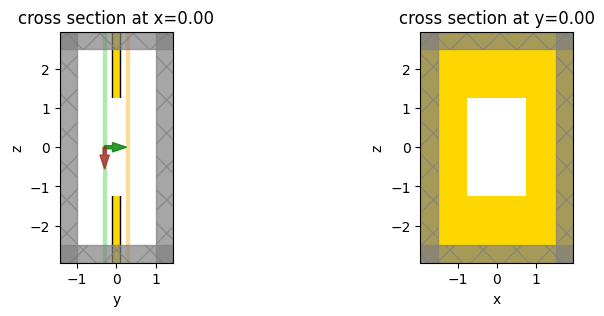

In [24]:
sim4 = td.Simulation(
    size=sim_size,
    center=[0, 0, 0],
    grid_spec=td.GridSpec.uniform(dl=wavelength / min_cells_per_wvl),
    structures=geometry,
    sources=[source],
    monitors=[monitor_intermediate_proj],  # only need to supply the projection monitor
    run_time=run_time,
    boundary_spec=boundary_spec,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sim4.plot(x=0, ax=ax1)
sim4.plot(y=0, ax=ax2)


In [25]:
# run the simulation
sim_data4 = web.run(sim4, task_name="aperture_4", path="data/aperture_4.hdf5")


[18:59:36] INFO     Created task 'aperture_4' with task_id 'bd6d281b-b683-48dc-b8de-341231e392e2'.    ]8;id=418610;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=926646;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\

Output()

[18:59:38] INFO     Maximum FlexUnit cost: 0.025                                                      ]8;id=511514;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=987878;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                                                   ]8;id=498658;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=414665;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#261\261]8;;\

Output()

[18:59:41] INFO     status = preprocess                                                               ]8;id=460914;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=880680;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#273\273]8;;\

[18:59:44] INFO     starting up solver                                                                ]8;id=400842;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=479484;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#277\277]8;;\

[18:59:53] INFO     running solver                                                                    ]8;id=251413;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=536158;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#283\283]8;;\

Output()

[18:59:56] INFO     early shutoff detected, exiting.                                                  ]8;id=249614;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=222534;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                                              ]8;id=36501;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=454324;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[18:59:57] INFO     status = success                                                                  ]8;id=952798;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=439936;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

[18:59:58] INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=795042;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=571111;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/aperture_4.hdf5"             ]8;id=454475;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=302512;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#592\592]8;;\

Output()

[18:59:59] INFO     loading SimulationData from data/aperture_4.hdf5                                  ]8;id=239127;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=423584;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#414\414]8;;\

Normalized RMSE for |E|, no far field approximation, computed on the server: 0.33 %

Client-side field projection *without approximations* took 11.41 s
Server-side field projection *without approximations* took 1.61 s


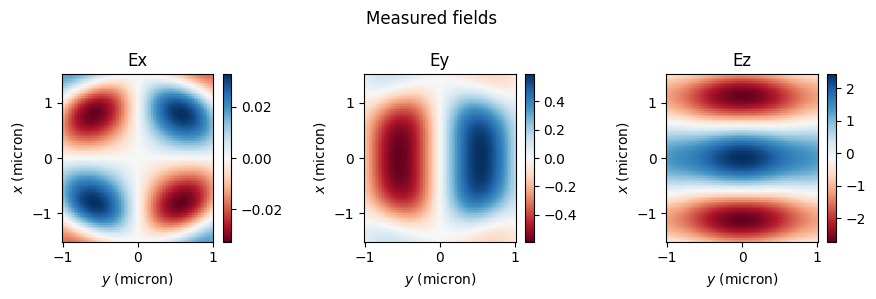

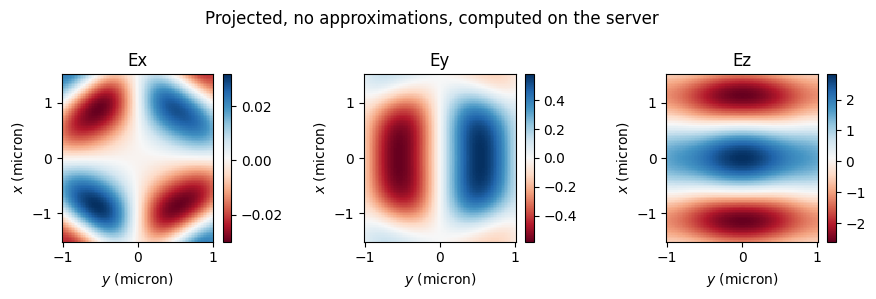

In [26]:
# extract the projected fields as before and plot them
projected_field_data_server = sim_data4[monitor_intermediate_proj.name]

# plot the actual measured fields from the previous simulation
fields_meas = sim_data3[monitor_intermediate.name].colocate(x=xs, z=ys)
make_cart_plot(
    ys,
    xs,
    fields_meas.Ex.isel(f=0, y=0),
    fields_meas.Ey.isel(f=0, y=0),
    fields_meas.Ez.isel(f=0, y=0),
)
plt.suptitle("Measured fields")

# projected field without approximations computed on the server
fields_proj_noapprox = projected_field_data_server.fields_cartesian
make_cart_plot(
    ys,
    xs,
    fields_proj_noapprox.Ex.isel(f=0, y=0),
    fields_proj_noapprox.Ey.isel(f=0, y=0),
    fields_proj_noapprox.Ez.isel(f=0, y=0),
)
plt.suptitle("Projected, no approximations, computed on the server")

# RMSE
Emag_proj_server = np.sqrt(
    np.abs(fields_proj_noapprox.Ex) ** 2
    + np.abs(fields_proj_noapprox.Ey) ** 2
    + np.abs(fields_proj_noapprox.Ez) ** 2
)
print(
    f"Normalized RMSE for |E|, no far field approximation, computed on the server: {rmse(Emag_meas.values, Emag_proj_server.values) * 100:.2f} %\n"
)

# use the simulation log to find the time taken for server-side computations
server_time = float(
    sim_data4.log.split("Field projection time (s):    ", 1)[1].split("\n", 1)[0]
)
print(
    f"Client-side field projection *without approximations* took {proj_time_new:.2f} s"
)
print(f"Server-side field projection *without approximations* took {server_time:.2f} s")

plt.show()


Again we get an excellent match, an even smaller error than the client-side computations, and over an order of magnitude speed-up!

### Reciprocal space monitor <a name="kspace"></a>

In addition to [FieldProjectionAngleMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionAngleMonitor) and [FieldProjectionCartesianMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionCartesianMonitor), one can also define the far field observation grid in reciprocal space using [FieldProjectionKSpaceMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldProjectionKSpaceMonitor).

To demonstrate, we'll compute the far field associated with a Gaussian beam propagating at an angle.

In [27]:
# create the Gaussian beam source positioned the same as the plane wave source above
gaussian_beam = td.GaussianBeam(
    center=(0, 0, -0.1 * wavelength),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction="+",
    pol_angle=0,
    angle_theta=np.pi / 6,  # angles are with respect to the source plane's normal axis
    angle_phi=np.pi / 4,  # angles are with respect to the source plane's normal axis
    waist_radius=2 * wavelength,
    waist_distance=-wavelength * 4,
)


<AxesSubplot: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

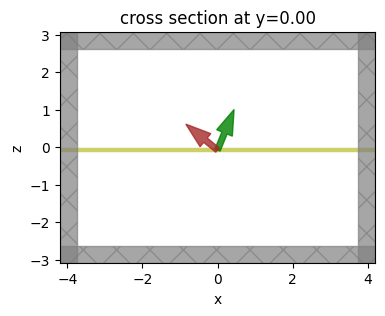

In [28]:
# create the k-space far field projection monitor
monitor_far = td.FieldProjectionKSpaceMonitor(
    center=[0, 0, -0.1 * wavelength],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name="far_field",
    ux=list(np.linspace(-0.7, 0.7, 100)),
    uy=list(np.linspace(-0.7, 0.7, 100)),
    proj_distance=50 * wavelength,
    proj_axis=2,  # projecting in the +y direction
    far_field_approx=True,  # use far field approximations
)

# create a simulation with the new source and monitor, and no PEC sheet
sim5 = td.Simulation(
    size=[10 * wavelength, 10 * wavelength, 7 * wavelength],
    center=[0, 0, 0],
    grid_spec=td.GridSpec.uniform(dl=wavelength / min_cells_per_wvl),
    structures=[],  # no PEC plate
    sources=[gaussian_beam],
    monitors=[monitor_far],
    run_time=run_time,
    boundary_spec=boundary_spec,
)

fig, (ax) = plt.subplots(1, 1, figsize=(7, 3))
sim5.plot(y=0, ax=ax)


### Run simulation

In [29]:
sim_data5 = web.run(sim5, task_name="kspace_monitor", path="data/kspace_monitor.hdf5")


           INFO     Created task 'kspace_monitor' with task_id                                        ]8;id=898187;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=894271;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '9b673226-3954-45d0-844a-1f0e7998f749'.                                                        

Output()

[19:00:03] INFO     Maximum FlexUnit cost: 0.036                                                      ]8;id=308148;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=734497;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#252\252]8;;\

           INFO     status = queued                                                                   ]8;id=388370;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=612816;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#261\261]8;;\

Output()

[19:00:05] INFO     status = preprocess                                                               ]8;id=516842;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=230269;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#273\273]8;;\

[19:00:08] INFO     starting up solver                                                                ]8;id=457619;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=350171;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#277\277]8;;\

[19:00:17] INFO     running solver                                                                    ]8;id=550116;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=540647;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#283\283]8;;\

Output()

[19:00:20] INFO     early shutoff detected, exiting.                                                  ]8;id=941251;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=516401;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#294\294]8;;\

           INFO     status = postprocess                                                              ]8;id=152670;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=880059;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

Output()

[19:00:21] INFO     status = success                                                                  ]8;id=45412;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=943913;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#306\306]8;;\

           INFO     Billed FlexUnit cost: 0.025                                                       ]8;id=614241;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=17237;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#310\310]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to "data/kspace_monitor.hdf5"         ]8;id=31460;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=433335;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#592\592]8;;\

Output()

[19:00:23] INFO     loading SimulationData from data/kspace_monitor.hdf5                              ]8;id=96383;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=915363;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#414\414]8;;\

### Plot and compare
Extract and plot the fields. We use a polar plot, and observe that the far field spot is located along the `phi=45 deg` line, as expected. The angle `theta` is expected to be near `30 deg`, which is nearly what is observed in the plot. The small deviation is due to the way the fields are plotted - a better way would be to project the fields orthographically on the surface of a sphere prior to plotting.

/var/folders/80/rm392zc51jz32327xblmmg2c0000gn/T/ipykernel_77620/2062883249.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(


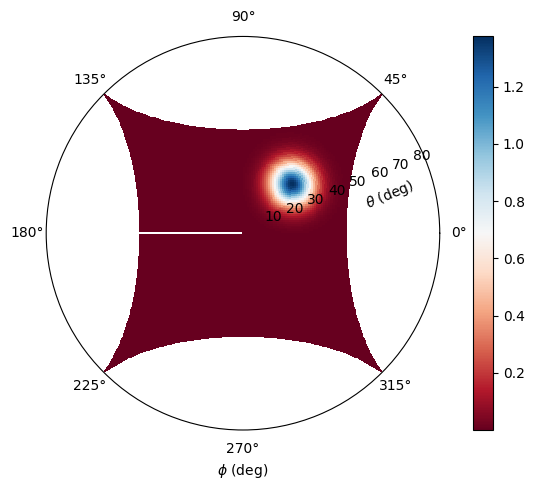

In [30]:
# extract the computed projected fields
far_data = sim_data5[monitor_far.name]

# We can compute the theta and phi angles associated with the given reciprocal coordinates
coords = far_data.coords_spherical
theta = coords["theta"]
phi = coords["phi"]

# plot
Etheta = far_data.Etheta.isel(f=0, r=0)
fig, ax = plt.subplots(
    1, 1, tight_layout=True, figsize=(7, 5), subplot_kw={"projection": "polar"}
)
ax.grid(False)
# im = ax.pcolormesh(np.squeeze(phi), np.squeeze(theta) * 180 / np.pi, np.abs(Etheta), cmap='RdBu', shading='auto')
im = ax.pcolormesh(
    np.squeeze(phi),
    np.squeeze(theta) * 180 / np.pi,
    np.abs(Etheta),
    cmap="RdBu",
    shading="auto",
)
fig.colorbar(im, ax=ax)
_ = ax.set_xlabel("$\phi$ (deg)")

label_position = ax.get_rlabel_position()
_ = ax.text(
    np.radians(label_position - 8),
    ax.get_rmax() / 1.3,
    "$\\theta$ (deg)",
    rotation=label_position,
    ha="center",
    va="center",
)

plt.show()


### Far Field for a Finite-Sized Structure
The above examples are very useful when simulating thin structure with a large extent in the lateral direction, such as a metasurface or metalens. If the structure is small enough, we may instead want to enclose it in a closed surface, which now serves as an equivalent surface in the spirit of the equivalence principle, without having to worry about whether the fields decay at the monitor's edges or not. To learn more, see the [sphere radar cross section](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Near2FarSphereRCS.html) and [plasmonic nanoparticle](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/PlasmonicNanoparticle.html) case studies.

### Notes <a name="notes"></a>
* Since field projections rely on the surface equivalence principle, we have assumed that the tangential near fields recorded on the near field monitor serve as equivalent sources which generate the correct far fields. However, this requires that the field strength decays nearly to zero near the edges of the near-field monitor, which may not always be the case. For example, if we had used a larger aperture compared to the full simulation size in the transverse direction, we may expect a degradation in accuracy of the field projections.
Despite this limitation, the field projections are still remarkably accurate in realistic scenarios. For realistic case studies further demonstrating the accuracy of the field projections, see our [metalens](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Metalens.html) and [zone plate](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/ZonePlateFieldProjection.html) case studies.
* The field projections make use of the analytical homogeneous medium Green's function, which assumes that the fields are propagating in a homogeneous medium. Therefore, one should use PMLs / absorbers as boundary conditions in the part of the domain where fields are projected. For far field projections in the context of perdiodic boundary conditions, see the [diffraction efficiency example](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/GratingEfficiency.html) which demonstrates the use of a [DiffractionMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.DiffractionMonitor).
* Server-side field projections will add to the monetary cost of the simulation. However, typically the far field projections have a very small computation cost compared to the FDTD simulation itself, so the increase in monetary cost should be negligibly small in most cases.